## Feature Selection Methods for Machine Learning

Feature selection - the act of reducing the number of features used for prediction in your final model - can have a positive impact on your model's performance.

There are several options available to us from within sklearn.

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, \
                            recall_score
import numpy as np
from time import time

# New import
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel


We're going to work with the processed titanic dataset - let's load it in.

In [2]:
try:
    data = pd.read_csv("data/processed_data.csv")

except FileNotFoundError:
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

data = data.astype(float)

# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

Let's create a list containing our feature names, as well as split our data into training, test and validation sets.

In [3]:
feature_names = X.columns.tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

print(f"Training Dataset Samples: {len(X_train)}")
print(f"Validation Dataset Samples: {len(X_validate)}")
print(f"Testing Dataset Samples: {len(X_test)}")

Training Dataset Samples: 569
Validation Dataset Samples: 143
Testing Dataset Samples: 179


Let's fit an initial model to see its performance.

In [4]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_validate)

We can also create a confusion matrix.

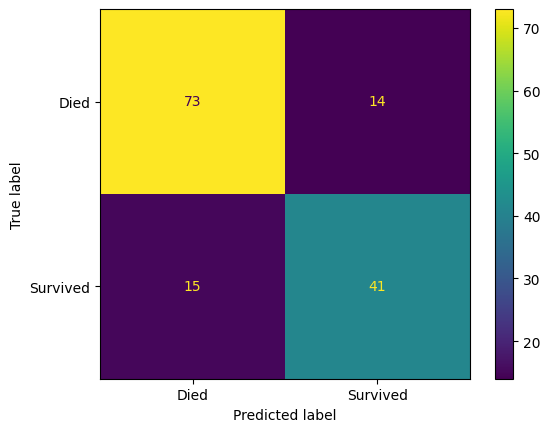

In [5]:
confusion_matrix_titanic = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_validate,
        y_pred=y_pred_val
        ),
        display_labels=["Died", "Survived"]
)

confusion_matrix_titanic.plot()

## Useful Function: Model evaluation

Let's create a function that can take a model as the input and 

We also have created an additional parameter that will be used to store the runtime for different instances; some of these might be quite long as feature selection can take a while!

In [6]:
def fit_train(X_train, X_validate, y_train, y_validate,
              name,
              feature_selection_runtime="N/A",
              model=XGBClassifier(random_state=42),
              show_confusion_matrix=False
              ):

     model.fit(X_train, y_train)

     y_pred_train = model.predict(X_train)
     y_pred_val = model.predict(X_validate)

     if show_confusion_matrix:
          confusion_matrix_titanic = ConfusionMatrixDisplay(
               confusion_matrix=confusion_matrix(
                    y_true=y_validate,
                    y_pred=y_pred_val
                    ),
                    display_labels=["Died", "Survived"]
               )

          confusion_matrix_titanic.plot()

     return pd.DataFrame({
          'Accuracy (training)': np.mean(y_pred_train == y_train).round(4),
          'Accuracy (validation)': np.mean(y_pred_val == y_validate).round(4),
          'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro').round(4),
          'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro').round(4),
          'features': ", ".join(X_train.columns.tolist()),
          'feature_selection_runtime': feature_selection_runtime

          }, index=[name]
)

Let's first use this to create a dataframe of results that just contains the results from running an xgboost model with all available features in use.

In [7]:
experiment_results_df = fit_train(X_train=X_train,
          X_validate=X_validate,
          y_train=y_train,
          y_validate=y_validate,
          name=f"XGBoost - all features ({len(X.columns)})")


experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
XGBoost - all features (24),0.9789,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A


## Forward Feature Selection

Forward feature selection starts by finding which single feature produces the best model.

It then iteratively goes through and adds additional features, in each case keeping the feature that adds the most predictive power.

We specify the model first, then record the time feature selection began. 

We then create a `SequentialFeatureSelector`, passing in the model, how many features we want to end up with, and whether to do 'forward' or 'backward' selection.

We then run fit on this, and when this has completed, it will record the duration.

In [8]:
model = XGBClassifier(random_state=42)

start_time = time()

sfs_forward = SequentialFeatureSelector(
    model, n_features_to_select=3, direction="forward"
)

sfs_forward.fit(X_train, y_train)

duration = time() - start_time

sfs_forward

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=42, ...),
                          n_features_to_select=3)

Let's explore what the output of this is.

In [9]:
sfs_forward.get_support()

array([False, False, False, False,  True, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

It looks like it's a *MASK*. This list of true and false values could be applied to an array so that we only keep the values in the array that match up with an instance of 'true' in the mask. 

Let's use the mask to get the actual feature names out instead and print these.

In [10]:
feature_names_selected_ff = np.array(feature_names)[sfs_forward.get_support()]

print(
    "Features selected by forward sequential selection: "
    f"{feature_names_selected_ff}"
)

Features selected by forward sequential selection: ['Fare' 'CabinNumber' 'male']


Let's now assess the performance of a model trained using just these features and als pass in the duration of the feature selection step (calculated two cells previously).

We pass the feature names we have obtained to the training and validation datasets to filter them down to just these cells.

In [11]:
experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train[feature_names_selected_ff],
          X_validate=X_validate[feature_names_selected_ff],
          y_train=y_train,
          y_validate=y_validate,
          feature_selection_runtime=f"{duration:.3f}s",
          name="Forward Feature Selection - 3")]
)

experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
XGBoost - all features (24),0.9789,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A
Forward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",203.124s


#### Repeat with 5 features

Let's do it again, seeing how much better 5 features perform and how long it takes.

In [12]:
model = XGBClassifier(random_state=42)

start_time = time()

sfs_forward_5 = SequentialFeatureSelector(
    model, n_features_to_select=5, direction="forward"
)

sfs_forward_5.fit(X_train, y_train)

duration = time() - start_time

feature_names_selected_ff_5 = np.array(feature_names)[sfs_forward_5.get_support()]

print(
    "Features selected by forward sequential selection: "
    f"{feature_names_selected_ff}"
)

Features selected by forward sequential selection: ['Fare' 'CabinNumber' 'male']


In [13]:
experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train[feature_names_selected_ff_5],
          X_validate=X_validate[feature_names_selected_ff_5],
          y_train=y_train,
          y_validate=y_validate,
          feature_selection_runtime=f"{duration:.3f}s",
          name="Forward Feature Selection - 5")]
)

experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
XGBoost - all features (24),0.9789,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A
Forward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",203.124s
Forward Feature Selection - 5,0.9262,0.8042,0.7967,0.7882,"Fare, CabinLetterImputed, CabinNumber, male, C...",106.305s


## Backward Feature Selection

The code is almost identical when we want to perform backward selection - we just use `direction="backward"` instead.

In [14]:
model = XGBClassifier(random_state=42)

start_time = time()

sfs_backward_3 = SequentialFeatureSelector(
    model, n_features_to_select=3, direction="backward"
)

sfs_backward_3.fit(X_train, y_train)

duration = time() - start_time

feature_names_selected_bf_3 = np.array(feature_names)[sfs_backward_3.get_support()]

print(
    "Features selected by backward sequential selection: "
    f"{feature_names_selected_bf_3}"
)

Features selected by backward sequential selection: ['Fare' 'CabinNumber' 'male']


In [15]:
experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train[feature_names_selected_bf_3],
          X_validate=X_validate[feature_names_selected_bf_3],
          y_train=y_train,
          y_validate=y_validate,
          feature_selection_runtime=f"{duration:.3f}s",
          name="Backward Feature Selection - 3")]
)

experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
XGBoost - all features (24),0.9789,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A
Forward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",203.124s
Forward Feature Selection - 5,0.9262,0.8042,0.7967,0.7882,"Fare, CabinLetterImputed, CabinNumber, male, C...",106.305s
Backward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",268.981s


Let's repeat with 5 and assess the performance.

In [16]:
model = XGBClassifier(random_state=42)

start_time = time()

sfs_backward_5 = SequentialFeatureSelector(
    model, n_features_to_select=5, direction="backward"
)

sfs_backward_5.fit(X_train, y_train)

duration = time() - start_time

feature_names_selected_bf_5 = np.array(feature_names)[sfs_backward_5.get_support()]

print(
    "Features selected by backward sequential selection: "
    f"{feature_names_selected_bf_5}"
)

Features selected by backward sequential selection: ['Pclass' 'Fare' 'CabinNumber' 'male' 'CabinLetter_E']


In [17]:
experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train[feature_names_selected_bf_5],
          X_validate=X_validate[feature_names_selected_bf_5],
          y_train=y_train,
          y_validate=y_validate,
          feature_selection_runtime=f"{duration:.3f}s",
          name="Backward Feature Selection - 5")]
)

experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
XGBoost - all features (24),0.9789,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A
Forward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",203.124s
Forward Feature Selection - 5,0.9262,0.8042,0.7967,0.7882,"Fare, CabinLetterImputed, CabinNumber, male, C...",106.305s
Backward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",268.981s
Backward Feature Selection - 5,0.9262,0.8042,0.7945,0.7945,"Pclass, Fare, CabinNumber, male, CabinLetter_E",179.093s


### The 'auto' parameter

We can also let SequentialFeatureSelector decide how many features to use.

In [18]:
model = XGBClassifier(random_state=42)

start_time = time()

sfs_backward_auto = SequentialFeatureSelector(
    model,
    n_features_to_select="auto",
    direction="backward"
)

sfs_backward_auto.fit(X_train, y_train)

duration = time() - start_time

feature_names_selected_bf_auto = np.array(feature_names)[sfs_backward_auto.get_support()]

print(
    "Features selected by backward sequential selection: "
    f"{feature_names_selected_bf_auto}"
)

Features selected by backward sequential selection: ['Pclass' 'SibSp' 'Parch' 'Fare' 'CabinNumber' 'male' 'Embarked_C'
 'Embarked_Q' 'Embarked_S' 'CabinLetter_D' 'CabinLetter_E'
 'CabinLetter_missing']


In [19]:
experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train[feature_names_selected_bf_auto],
          X_validate=X_validate[feature_names_selected_bf_auto],
          y_train=y_train,
          y_validate=y_validate,
          feature_selection_runtime=f"{duration:.3f}s",
          name="Backward Feature Selection - auto")]
)

experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
XGBoost - all features (24),0.9789,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A
Forward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",203.124s
Forward Feature Selection - 5,0.9262,0.8042,0.7967,0.7882,"Fare, CabinLetterImputed, CabinNumber, male, C...",106.305s
Backward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",268.981s
Backward Feature Selection - 5,0.9262,0.8042,0.7945,0.7945,"Pclass, Fare, CabinNumber, male, CabinLetter_E",179.093s
Backward Feature Selection - auto,0.9385,0.8042,0.7942,0.7977,"Pclass, SibSp, Parch, Fare, CabinNumber, male,...",74.881s


## Using Feature Importance for Feature Selection

We could also use some of the feature importance metrics we've explored in previous sessions to make a judgment of which features to keep in our model.

The `SelectFromModel` function works with any model that has a `featur_importances_` attribute.

e.g.

For logistic regression, this will be model coefficients.

For decision trees, this will be mean decrease in impurity. 

We can determine the threshold we are going to use for keeping features in the model.

In [20]:
start_time = time()

model = XGBClassifier(random_state=42)

selector = SelectFromModel(
    estimator=model,
    threshold=0.03
    )

selector.fit(X_train, y_train)

duration = time() - start_time

In [21]:
selector.estimator_.feature_importances_

array([0.15078323, 0.03309093, 0.04509973, 0.03712323, 0.03330522,
       0.01645992, 0.        , 0.02637349, 0.0527233 , 0.        ,
       0.38024062, 0.03597496, 0.02359743, 0.03333741, 0.        ,
       0.        , 0.        , 0.02592567, 0.04060741, 0.06535744,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [22]:
selector.threshold_

0.03

Similarly to before, we can use 'get_support'. 

In [23]:
selector.get_support()

array([ True,  True,  True,  True,  True, False, False, False,  True,
       False,  True,  True, False,  True, False, False, False, False,
        True,  True, False, False, False, False])

In [24]:
feature_names_selected_fi_03 = np.array(feature_names)[selector.get_support()]
feature_names_selected_fi_03

array(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'CabinNumber', 'male',
       'Embarked_C', 'Embarked_S', 'CabinLetter_D', 'CabinLetter_E'],
      dtype='<U19')

In [25]:
experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train[feature_names_selected_fi_03],
          X_validate=X_validate[feature_names_selected_fi_03],
          y_train=y_train,
          y_validate=y_validate,
          feature_selection_runtime=f"{duration:.3f}s",
          name="Feature Importance Selection - Threshold 0.03")]
)

experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
XGBoost - all features (24),0.9789,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A
Forward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",203.124s
Forward Feature Selection - 5,0.9262,0.8042,0.7967,0.7882,"Fare, CabinLetterImputed, CabinNumber, male, C...",106.305s
Backward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",268.981s
Backward Feature Selection - 5,0.9262,0.8042,0.7945,0.7945,"Pclass, Fare, CabinNumber, male, CabinLetter_E",179.093s
Backward Feature Selection - auto,0.9385,0.8042,0.7942,0.7977,"Pclass, SibSp, Parch, Fare, CabinNumber, male,...",74.881s
Feature Importance Selection - Threshold 0.03,0.9807,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, CabinNumber, ...",0.193s


Let's try tweaking with a different model.

In [26]:
experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train,
          X_validate=X_validate,
          y_train=y_train,
          y_validate=y_validate,
          model=RandomForestClassifier(random_state=42, max_depth=6),
          name=f"Random Forest - all features ({len(X_train.columns)})")]
)

experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
XGBoost - all features (24),0.9789,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A
Forward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",203.124s
Forward Feature Selection - 5,0.9262,0.8042,0.7967,0.7882,"Fare, CabinLetterImputed, CabinNumber, male, C...",106.305s
Backward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",268.981s
Backward Feature Selection - 5,0.9262,0.8042,0.7945,0.7945,"Pclass, Fare, CabinNumber, male, CabinLetter_E",179.093s
Backward Feature Selection - auto,0.9385,0.8042,0.7942,0.7977,"Pclass, SibSp, Parch, Fare, CabinNumber, male,...",74.881s
Feature Importance Selection - Threshold 0.03,0.9807,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, CabinNumber, ...",0.193s
Random Forest - all features (24),0.8822,0.7972,0.7870,0.7888,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A


In [27]:
selector = SelectFromModel(estimator=RandomForestClassifier(random_state=42, max_depth=6), threshold="mean").fit(X_train, y_train)
selector.estimator_.feature_importances_

array([6.66890927e-02, 1.03772923e-01, 4.78576994e-02, 3.96696333e-02,
       1.29373457e-01, 1.25008170e-02, 1.55485193e-04, 3.27266742e-02,
       8.05041446e-02, 4.58115404e-02, 3.09684642e-01, 1.31952009e-02,
       7.36228867e-03, 2.11471973e-02, 9.83537258e-06, 2.28944280e-03,
       1.19636370e-02, 1.08809761e-02, 5.33431862e-03, 1.15495213e-02,
       2.40979415e-03, 8.87648714e-04, 0.00000000e+00, 4.42240310e-02])

In [28]:
feature_names_selected_fi_rf_mean = np.array(feature_names)[selector.get_support()]
feature_names_selected_fi_rf_mean

experiment_results_df = pd.concat([experiment_results_df,
    fit_train(X_train=X_train[feature_names_selected_fi_rf_mean],
          X_validate=X_validate[feature_names_selected_fi_rf_mean],
          y_train=y_train,
          y_validate=y_validate,
          model=RandomForestClassifier(random_state=42, max_depth=6),
          name=f"Random Forest - Mean Feature Importance Threshold ({len(feature_names_selected_fi_rf_mean)})")]
)

experiment_results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),features,feature_selection_runtime
XGBoost - all features (24),0.9789,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A
Forward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",203.124s
Forward Feature Selection - 5,0.9262,0.8042,0.7967,0.7882,"Fare, CabinLetterImputed, CabinNumber, male, C...",106.305s
Backward Feature Selection - 3,0.9244,0.8112,0.8052,0.7939,"Fare, CabinNumber, male",268.981s
Backward Feature Selection - 5,0.9262,0.8042,0.7945,0.7945,"Pclass, Fare, CabinNumber, male, CabinLetter_E",179.093s
Backward Feature Selection - auto,0.9385,0.8042,0.7942,0.7977,"Pclass, SibSp, Parch, Fare, CabinNumber, male,...",74.881s
Feature Importance Selection - Threshold 0.03,0.9807,0.7972,0.7875,0.7856,"Pclass, Age, SibSp, Parch, Fare, CabinNumber, ...",0.193s
Random Forest - all features (24),0.8822,0.7972,0.7870,0.7888,"Pclass, Age, SibSp, Parch, Fare, AgeImputed, E...",N/A
Random Forest - Mean Feature Importance Threshold (8),0.8946,0.8322,0.8239,0.8239,"Pclass, Age, SibSp, Fare, CabinNumber, CabinNu...",N/A
